In [13]:
from cProfile import label

import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.pylabtools import figsize
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [14]:
data = pd.read_csv('winequality-red.csv',sep=";")

# z-score all columns
colsZscore = data.keys()
colsZscore = colsZscore.drop("quality")
data[colsZscore] = data[colsZscore].apply(stats.zscore)

data["boolQuality"] = 0

data["boolQuality"][data["quality"] > 5] = 1


C:\Users\User\AppData\Local\Temp\ipykernel_16308\352976115.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["boolQuality"][data["quality"] > 5] = 1
C:\Users\User\AppData\Local\Temp\ipykernel_16308\352976115.py:10: SettingWithCopyWar

In [15]:
data = data[data["total sulfur dioxide"] < 200]

In [16]:
dataT = torch.tensor(data[colsZscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:,None] # transform to matrix

In [17]:
train_data,test_data,train_labels,test_labels=train_test_split(dataT,labels,test_size=.2)

train_dataSet = TensorDataset(train_data,train_labels)
test_dataset = TensorDataset(test_data,test_labels)

test_loader = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataSet,batch_size=32,shuffle=True,drop_last=True)

In [18]:
class NetWithBNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input = nn.Linear(11,16)
        
        self.fc1 = nn.Linear(16,32)
        self.bnorm1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(32,20)
        self.bnorm2 = nn.BatchNorm1d(32)
        
        
        self.output = nn.Linear(20,1)
        
    def forward(self,x,doBN):
        
        x = F.relu(self.input(x))
        
        if doBN:
            
            x = self.bnorm1(x)
            x = F.relu(self.fc1(x))
            
            x = self.bnorm2(x)
            x = F.relu(self.fc2(x))
            
        else:
            
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
        
        return self.output(x)
    
        
        

In [19]:
num_epoch = 1000

def trainModel(doBN=True):
    
    lossFn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(wineNet.parameters(), lr=0.01)
    
    losses = torch.zeros(num_epoch)
    trainAcc = []
    testAcc = []
    
    for epochI in range(num_epoch):
        
        wineNet.train()
        
        batchAcc = []
        batchLoss =[]
        for X,y in train_loader:
            
            yHat = wineNet(X,doBN=doBN)
            loss = lossFn(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            batchAcc.append( 100*torch.mean(((yHat > 0) == y).float()).item())
            
        trainAcc.append( np.mean(batchAcc))
        
        losses[epochI] = np.mean(batchLoss)
        
        ### test acc
        wineNet.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = wineNet(X,doBN=doBN)
        testAcc.append( 100*torch.mean(((yHat > 0) == y).float()).item())
        
    return trainAcc,testAcc,losses

### Now Experiment

In [ ]:
wineNet = NetWithBNorm()
trainAcc,testAcc,losses = trainModel(False)

wineNet = NetWithBNorm()
trainAccWith,testAccWith,lossesWith = trainModel(True)


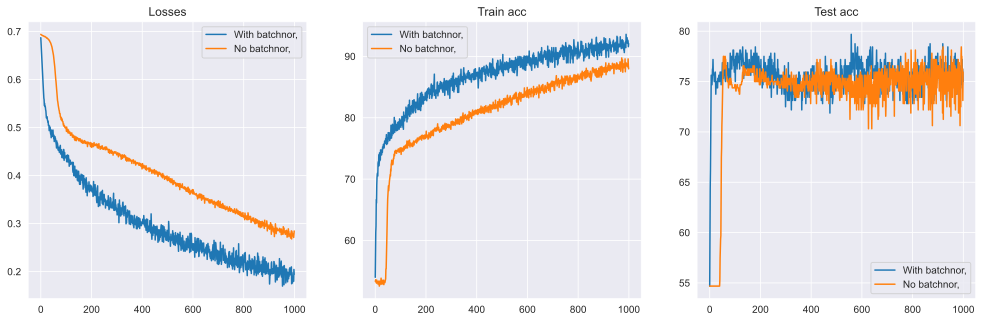

In [12]:
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(lossesWith,label="With batchnor,")
ax[0].plot(losses,label="No batchnor,")
ax[0].set_title("Losses")
ax[0].legend()

ax[1].plot(trainAccWith,label="With batchnor,")
ax[1].plot(trainAcc,label="No batchnor,")
ax[1].set_title("Train acc")
ax[1].legend()

ax[2].plot(testAccWith,label="With batchnor,")
ax[2].plot(testAcc,label="No batchnor,")
ax[2].set_title("Test acc")
ax[2].legend()

plt.show()